In [21]:
### Setup
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.2f' % x) # change decimal places

In [22]:
### Set Random-Seed
RSEED = 666

### Get Data
df_train = pd.read_csv('data/Train.csv')

### Columns to keep
### List of weather and satellite measurement_columns to keep
col_keep = list(df_train.columns[0:14]) + ['L3_AER_AI_absorbing_aerosol_index', # AER
                # CLOUD
                'L3_CLOUD_cloud_base_height',
                'L3_CLOUD_cloud_fraction',
                'L3_CLOUD_cloud_optical_depth',
                ## NO2
                'L3_NO2_NO2_column_number_density',
                #'L3_NO2_absorbing_aerosol_index',
                #'L3_NO2_cloud_fraction',
                ## CO
                'L3_CO_CO_column_number_density',
                #'L3_CO_cloud_height',
                ## HCHO
                'L3_HCHO_tropospheric_HCHO_column_number_density',
                #'L3_HCHO_cloud_fraction',
                ## O3
                'L3_O3_O3_column_number_density',
                #'L3_O3_cloud_fraction',
                ## SO2
                'L3_SO2_SO2_column_number_density'
                #'L3_SO2_absorbing_aerosol_index',
                #'L3_SO2_cloud_fraction'
                ]

In [23]:
### Subset of df_train for plotting the time-series of target for 4 most different places
ind_place = ["IM6VR3X", "IOLPRPO", "010Q650", "JSXAVKO"] ### 4 places with full 92 instances

# Subset rows only the places in ind_place and with the three named columns
df_target_plot = df_train.loc[df_train.Place_ID.isin(ind_place), ["Date", "Place_ID", "target"]]

# Date as DateTime 
df_target_plot["Date"] = pd.to_datetime(df_target_plot.Date)

In [24]:
### Faceted lineplot with sns.relplot by Place_ID
plt.clf()
fig = sns.relplot(data = df_target_plot, x = "Date", y = "target", col = "Place_ID", kind = "line", col_wrap = 2)
fig.set_xticklabels(rotation = 45)
fig.savefig("./plots/timeseries_target.png")
plt.clf()


<Figure size 800x500 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [25]:
### Define sets of columns for preprocessing
### Columns to keep in X for train test split
col_X = [col_keep[2]] + col_keep[8:len(col_keep)]

### Columns with meaningless 0 values
col_zero = [#"L3_NO2_absorbing_aerosol_index", 
"L3_CO_CO_column_number_density", "L3_O3_O3_column_number_density"]#, "L3_O3_cloud_fraction", "L3_SO2_absorbing_aerosol_index"]

### Numeric columns without meaningless, inflated zeros and some of them NAN - treated together to remove NaNs
col_nan = col_X[1:7] + col_keep[14:]

### Categorical columns to Integer Values - Place_id
col_cat = ["Place_ID"]

### Columns for transforming - Windspeed - do this first, since no one else has done it in the pipelines
col_wind = col_keep[12:14]

In [26]:
### Turn col_zero and col_nan to mutually exclusive lists
print (col_zero)
print (col_nan)

### Are all col_zeros in col_nan?
def x_in_y(x, y):
    len_x = len(x)
    len_y = len(y)

    k = 0
    for i in x:
        if i in y: 
            k += 1
    return k, len_x

### How many of col_zero are in col_nan
print(x_in_y(col_zero, col_nan))

### All values of col_zero are in col_nan
print(len(col_nan))

### Remove col_zero values from col_nan
for i in col_zero:
    col_nan.remove(i)

### Have they changed?
print(len(col_nan))
print(x_in_y(col_zero, col_nan))


['L3_CO_CO_column_number_density', 'L3_O3_O3_column_number_density']
['precipitable_water_entire_atmosphere', 'relative_humidity_2m_above_ground', 'specific_humidity_2m_above_ground', 'temperature_2m_above_ground', 'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground', 'L3_AER_AI_absorbing_aerosol_index', 'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_optical_depth', 'L3_NO2_NO2_column_number_density', 'L3_CO_CO_column_number_density', 'L3_HCHO_tropospheric_HCHO_column_number_density', 'L3_O3_O3_column_number_density', 'L3_SO2_SO2_column_number_density']
(2, 2)
15
13
(0, 2)


In [27]:
### Create a custom Transformer to include in the Pipeline for casting the two windspeed columns to one combined
### windspeed column

class WindSpeedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_combined_windspeed=True): # no *args or **kargs
        self.add_combined_windspeed = add_combined_windspeed

    def fit(self, X, y=None):
        return self  # nothing else to do - since no values are stored, and therefore no fitting is applied to test data
    
    def transform(self, X):
        combined_windspeed = np.sqrt((X["u_component_of_wind_10m_above_ground"])**2 + (X["v_component_of_wind_10m_above_ground"])**2)

        if self.add_combined_windspeed:
            return np.c_[combined_windspeed] # Return only new windspeed column casted to 2D array
        else:
            return X    

In [28]:
### Train

df_x = df_train[col_X]
y = df_train.target

X_train, X_test, y_train, y_test = train_test_split(df_x, y, test_size = 0.3, random_state = RSEED, shuffle = True)

In [29]:
### 3 Categories:
### column with meaningless zeros and nans
# col_zero
# 1 replace nan with zero
# 2 replace all zeros with median
# 3 scale the data
zero_pipeline = Pipeline([
    ("col_zero_nan_imputer", SimpleImputer(strategy="constant", fill_value=0)), # Replace NaNs with zero
    ("col_zero_zero_imputer", SimpleImputer(strategy="median", missing_values=0)) # Replace Zeros with Median
    #, ("col_zero_standard_scaler", StandardScaler()) Scaling
])

### columns without meaningless zeros but nans, 
### can also include the features without meaningless zeros and without nans (weather measurements)
# col_nan
# 1 replace Nan with median
# 2 scale the data
nan_pipeline = Pipeline([
    ("col_nan_imputer", SimpleImputer(strategy = "median")) # Replace NaN with median
    #, ("col_nan_standard_scaler", StandardScaler()) Scaling
])

### Columns for transforming wind-speed
# col_wind
# 1 create new windspeed column from both np.sqrt((u)**2 + (v)**2)
# 2 drop u and v?
# 3 scale the data
wind_pipeline = Pipeline([
    ("col_wind_windspeed_transformer", WindSpeedTransformer()) # Apply Windspeedtransformation. Drops the original columns
    #, ("col_wind_standard_scaler", StandardScaler()) Scaling 
])

### columns with categorical variable but no nans
# col_cat
# 1 transform objects into integers for random forests
cat_pipeline = Pipeline([
    ("col_cat_OrdinalEncoder", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value=-1))
])

In [30]:
### Construct Preprocessor Pipeline of single Pipes
preprocessor = ColumnTransformer([
    ("col_zero_transformer", zero_pipeline, col_zero),
    ("col_nan_transformer", nan_pipeline, col_nan),
    ("wind_transformer", wind_pipeline, col_wind),
    ("cat_transformer", cat_pipeline, col_cat) # 1D Data Error happening here
],  remainder = "drop") # To drop all columns which are not returned by the single pipelines

In [31]:
### Define Parameter Grid for RandomForest Calculation
min_samples = list(range(2,20,2)) + list(range(30,110,10))
max_leafs = list(range(200,1100,200)) + list(range(1000,11000, 1000))
max_feats = ["sqrt"] + list(np.arange(0.1,1.1, 0.1))
max_depths = list(range(5, 41, 5))
splitrs = ["best", "random"]
criters = ["squared_error", # corresponding to L1
          "friedman_mse", 
          "absolute_error"] # Corresponding to L2

### Create Pipeline for RandomForest Grid Search
param_grid_rf = { 'test_random_forest__max_depth': max_depths,
    'test_random_forest__max_features': max_feats,
    'test_random_forest__max_leaf_nodes': max_leafs,
    'test_random_forest__min_samples_split': min_samples,
    'test_random_forest__criterion' : ["squared_error"]} ### Not tested for multiple error criterion
    # 'bootstrap': [True, False]} - Not found in Documentation of DecisionTreeRegressor and Classifier

In [32]:
### Create Full Pupeline from Preprocessing to RandomForestRegressor
pipe_rf_test = Pipeline([
    ("preprocessor", preprocessor),
    ("test_random_forest", RandomForestRegressor(random_state = RSEED))
])

In [33]:
### Define GridSearchObject which takes in the pipeline as MainObject
grid_rf_test = RandomizedSearchCV(pipe_rf_test, param_distributions = param_grid_rf, 
                            verbose = True,
                            scoring = "neg_root_mean_squared_error", 
                            cv=5, 
                            n_jobs = -1,
                            n_iter = 30,
                            random_state = RSEED)
### And fit

grid_rf_test.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('col_zero_transformer',
                                                                               Pipeline(steps=[('col_zero_nan_imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('col_zero_zero_imputer',
                                                                                                SimpleImputer(missing_values=0,
                                                                                                              strategy='median'))]),
                                                   

In [34]:
### Simple Function to predict values and display Error-Values
def get_rf_infos(pipe_object, X_tr, X_te, y_tr, y_te): # 
    ### parameters
    #print("Best parameters: ")
    #print(pipe_object.best_estimator_.get_params())

    ### Predict
    y_rf_train_predict = pipe_object.best_estimator_.predict(X_tr)
    y_rf_test_predict = pipe_object.best_estimator_.predict(X_te)
    
    ### R^2
    print ("R^2 train, R^2 test:")
    print(r2_score(y_rf_train_predict, y_tr).round(2))
    print(r2_score(y_rf_test_predict, y_te).round(2))

    ### RMSE
    print("RMSE train, RMSE test:")
    print(np.sqrt(mean_squared_error(y_rf_train_predict, y_tr)).round(2))
    print(np.sqrt(mean_squared_error(y_rf_test_predict, y_te)).round(2))

    ### MAPE
    print ("Mean absolute percentage Error train, MAPE test:")
    print(mean_absolute_percentage_error(y_rf_train_predict, y_tr).round(2))
    print(mean_absolute_percentage_error(y_rf_test_predict, y_te).round(2))
    return y_rf_train_predict, y_rf_test_predict


In [35]:
### Get Error Values from best RandomForest
y_rf_train_predict, y_rf_test_predict = get_rf_infos(grid_rf_test, X_train, X_test, y_train, y_test)


R^2 train, R^2 test:
0.84
0.02
RMSE train, RMSE test:
15.02
30.72
Mean absolute percentage Error train, MAPE test:
0.18
0.37


In [36]:
### Error Analysis Plot
def error_analysis(y_test, y_pred):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis - Random Forest Model')
    
    ax[0].scatter(y_pred, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred.min()-10), (y_pred.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred.min()-10), (y_pred.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

<Figure size 800x500 with 0 Axes>

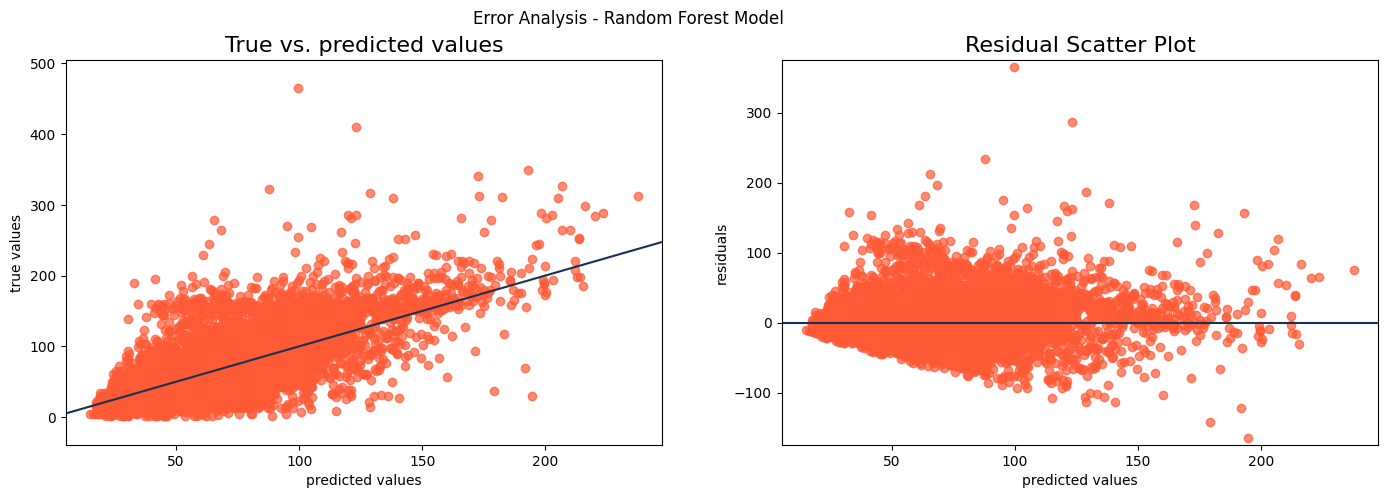

In [37]:
# Plot Error Analysis
plt.clf()
error_analysis(y_test, y_rf_test_predict)
plt.savefig("./plots/rf_resid.png")

In [38]:
### Get hyperparameter-values and the error score from RandomizedSearchCV Object for Error Analysis
df_grid_rf = pd.DataFrame(grid_rf_test.cv_results_)

### Number of columns used in RandomForest
repl_val = np.sqrt(len(col_X)-1)/(len(col_X)-1) # sqrt
repl_val = str(repl_val.round(2))

# Ersetzen sqrt in param_test_random_forest__max_features
df_grid_rf.param_test_random_forest__max_features.replace("sqrt", repl_val, inplace = True)
df_grid_rf.param_test_random_forest__max_features = df_grid_rf.param_test_random_forest__max_features.astype("float")

df_grid_rf["index1"] = df_grid_rf.index
df_grid_rf.iloc[:,[4,5,7]] = df_grid_rf.iloc[:,[4,5,7]].astype("int")

In [39]:
### Turn into long DF for plotting
df_1 = pd.melt(df_grid_rf, id_vars = "index1", value_vars = ['param_test_random_forest__min_samples_split',
       'param_test_random_forest__max_leaf_nodes',
       'param_test_random_forest__max_features',
       'param_test_random_forest__max_depth'],
       var_name = "hyperparameter", 
       value_name = "hyperparameter_value")

### Subset to the three desired columns
df_2 = df_grid_rf[["index1", "mean_test_score", "std_test_score"]]

### Merge to get the desired DF in long format
df_grid_rf = df_1.merge(df_2, on = "index1")

### Clean hyperparameter variable name
df_grid_rf.hyperparameter = df_grid_rf.hyperparameter.str.replace("param_test_random_forest__", "")

### Turn mean test score into positive values
df_grid_rf.mean_test_score = df_grid_rf.mean_test_score * -1
### For pointing out the best estimator value - Column to indicate this
df_grid_rf["Best_Estimator"] = df_grid_rf.mean_test_score == df_grid_rf.mean_test_score.min() 

<Figure size 800x500 with 0 Axes>

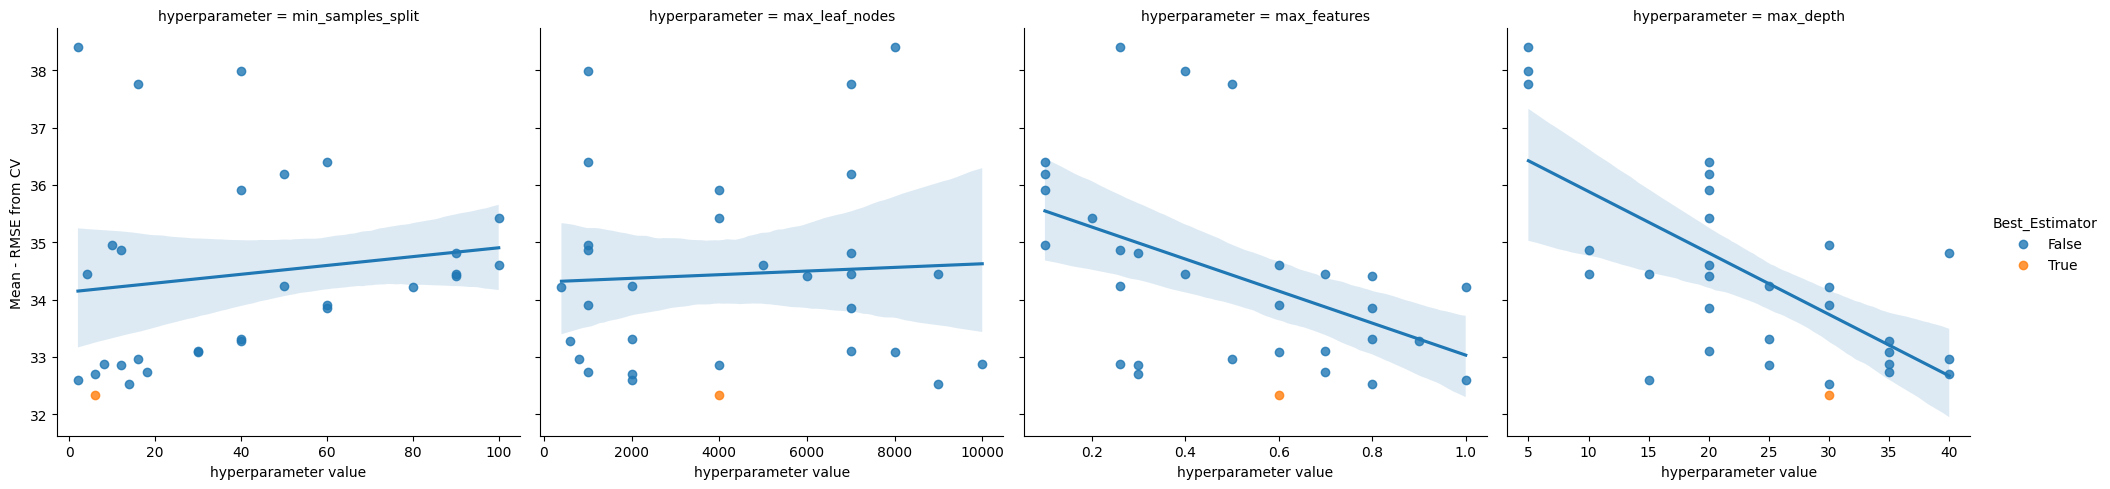

In [40]:
# Plot MeanError from CrossValidation Runs in RandomizedSearch against the hyperparameter values in faceted scatterplot
# Highlight the relationship with lmplot
plt.clf()
fig = sns.lmplot(data = df_grid_rf, x = "hyperparameter_value", y = "mean_test_score", 
                 col = "hyperparameter", hue = "Best_Estimator", facet_kws=dict(sharex=False))
fig.set(xlabel = "hyperparameter value", ylabel = "Mean - RMSE from CV")
plt.savefig("./plots/rf_rmse_hyperparams.png")